In [2]:
# Do not run this cell, it is to preprocess the epubs to text files

from sentence_transformers import SentenceTransformer,util
import re
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import re


def read_epub(file_path):
    book = epub.read_epub(file_path)
    text = ""
    
    for item in book.get_items():
        

        if item.get_type() == ebooklib.ITEM_DOCUMENT:

            # Convert the HTML content to plain text
            text += item.get_content().decode('utf-8')
    
    return text

def save_text_to_file(text, output_file):
    soup = BeautifulSoup(text, 'html.parser')
    div_elements = soup.find_all('p', {'class': ['indent']})
    parsed = ""

    for div in div_elements:

        # For Quaran text : remove the verse number, verser number is present at the start of the text
        parsed += re.sub(r'^\d+ ', '', div.text) + "\n"

    with open(output_file, 'w') as file:
        file.write(parsed)
        # file.write(text)

        
    

# Specify the file paths
epub_file_path = 'books/quran.epub'
output_file_path = 'books/quran.txt'

# Read the EPUB file
epub_text = read_epub(epub_file_path)

# Save the text to a text file
save_text_to_file(epub_text, output_file_path)





/Users/kevin/coding/SentenceGPT/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kevin/coding/SentenceGPT/.venv/lib/python3.9/site-packages/ebooklib/epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')


In [30]:
# Testing out of vocab (OOV) words

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

senetences = [
    "Our Kṛṣṇa consciousness movement is genuine, historically authorized, natural and transcendental due to its being based on Bhagavad-gītā"
]


tokenizer = model.tokenizer
tokens = [e.tokens for e in tokenizer(senetences, padding='longest', truncation=True).encodings ]

print(tokens)

tokenized_senetence = model.tokenize(senetences)


[['[CLS]', 'our', 'k', '##rs', '##na', 'consciousness', 'movement', 'is', 'genuine', ',', 'historically', 'authorized', ',', 'natural', 'and', 'trans', '##cend', '##ental', 'due', 'to', 'its', 'being', 'based', 'on', 'b', '##ha', '##ga', '##va', '##d', '-', 'gi', '##ta', '[SEP]']]


In [61]:
import re

def preprocess(text):
    
    # remove all the extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # remove all the punctuations except full stop
    text = re.sub(r'[^\w\s\.]', '', text)


    # split the text into sentences with full stop or new line
    sentences = re.split(r'[\.\n]', text)


    return sentences

def preproces_gita(text):

    # Replace few words with the correct words
    replace_list = [("Kṛṣṇa" , "God")]
    for item in replace_list:
        text = text.replace(item[0], item[1])
    
    # remove all the extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # remove all the punctuations except full stop
    text = re.sub(r'[^\w\s\.]', '', text)


    # split the text into sentences with full stop or new line
    sentences = re.split(r'[\.\n]', text)
    
    return sentences

def process_bible(text):

    # remove all the new lines 
    text = re.sub(r'\n', ' ', text)
    # remove all the extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # remove all the punctuations except full stop
    text = re.sub(r'[^\w\s\.]', '', text)
    # split the text into sentences with full stop or new line
    sentences = re.split(r'[\.\n]', text)

    #combine 3 senetences into one
    # sentences = [sentences[i] + " " + sentences[i+1] + " " + sentences[i+2] for i in range(0, len(sentences)-2, 3)]

    return sentences


In [63]:
quran = open('books/quran.txt', 'r').read()
gita = open('books/gita.txt', 'r').read()
bible = open('books/bible_raw.txt', 'r').read()

quran_sentences = preprocess(quran)
gita_sentences = preproces_gita(gita)
bible_sentences = process_bible(bible)

print(f'Quran : {len(quran_sentences)} sentences')
print(f'Gita : {len(gita_sentences)} sentences')
print(f'Bible : {len(bible_sentences)} sentences')


Quran : 8697 sentences
Gita : 9050 sentences
Bible : 26203 sentences


In [64]:
from sentence_transformers import SentenceTransformer,util

# Load the model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model = SentenceTransformer('all-MiniLM-L6-v2')
# model = SentenceTransformer('all-mpnet-base-v2')

# Encode the sentences
quran_embeddings = model.encode(quran_sentences)
gita_embeddings = model.encode(gita_sentences)
bible_embeddings = model.encode(bible_sentences)


In [72]:
import torch
# Find the cosisne similarity between the sentences of all the 3 types 
quran_gita_similarity = util.pytorch_cos_sim(quran_embeddings, gita_embeddings)
quran_bible_similarity = util.pytorch_cos_sim(quran_embeddings, bible_embeddings)

bible_gita_similarity = util.pytorch_cos_sim(bible_embeddings, gita_embeddings)
bible_quarn_similarity = util.pytorch_cos_sim(bible_embeddings, quran_embeddings)

gita_bible_similarity = util.pytorch_cos_sim(gita_embeddings, bible_embeddings)
gita_quran_similarity = util.pytorch_cos_sim(gita_embeddings, quran_embeddings)

threshold = 0.5

# Remove all bible sentences that are not similar to any other sentences
bible_embeddings_filtered = [bible_embeddings[i] for i in range(len(bible_sentences)) if torch.max(bible_gita_similarity[i]) > threshold or torch.max(bible_quarn_similarity[i]) > threshold]

# Remove all gita sentences that are not similar to any other sentences
gita_embeddings_filtered = [gita_embeddings[i] for i in range(len(gita_sentences)) if torch.max(gita_bible_similarity[i]) > threshold or torch.max(gita_quran_similarity[i]) > threshold]

# Remove all quran sentences that are not similar to any other sentences
quran_embeddings_filtered = [quran_embeddings[i] for i in range(len(quran_sentences)) if torch.max(quran_gita_similarity[i]) > threshold or torch.max(quran_bible_similarity[i]) > threshold]






0 21903
21903 29554
29554 36407


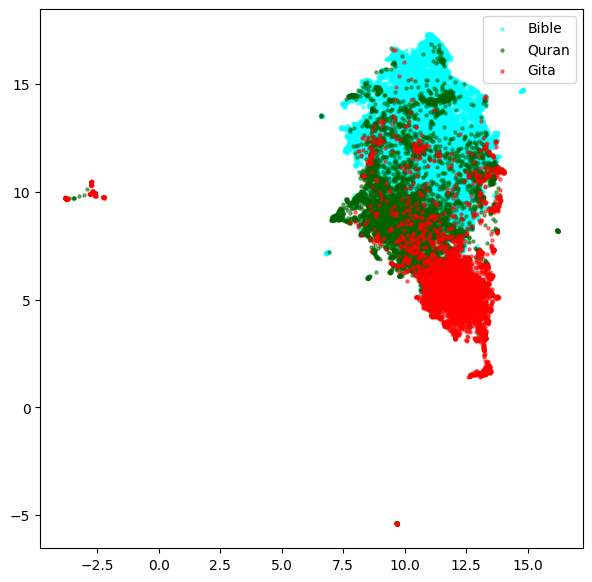

In [75]:
# visualize using umap
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt

embeddings = np.concatenate([bible_embeddings_filtered, quran_embeddings_filtered ,gita_embeddings_filtered])
umap = umap.UMAP(metric='cosine')
embeddings_2d = umap.fit_transform(embeddings)

# seperate the embeddings using for loop
sizes = [len(bible_embeddings_filtered),len(quran_embeddings_filtered), len(gita_embeddings_filtered)]
colors = ['aqua','darkgreen', 'red']
labels = ['Bible','Quran', 'Gita']



# Add an extra dimension to the embeddings_2d with value zero
embeddings_2_plot = np.zeros((embeddings_2d.shape[0], 3))
embeddings_2_plot[:, :2] = embeddings_2d


plt.figure(figsize=(7, 7))
# plt.figure(figsize=(15, 15))

# # print each point seperately
# for i in range(len(embeddings_2d)):
#     plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], s=0.5)


for i in range(len(sizes)):
    print(sum(sizes[:i]), sum(sizes[:i+1]))

    plt.scatter(embeddings_2d[sum(sizes[:i]):sum(sizes[:i+1]), 0], embeddings_2d[sum(sizes[:i]):sum(sizes[:i+1]), 1], color=colors[i], label=labels[i], s=5, alpha=0.5)

plt.legend()
plt.show()


